# STYLEGAN USING PYTORCH
This notebook is about StyleGAN from the paper A Style-Based Generator Architecture for Generative Adversarial Networks Ref: https://arxiv.org/pdf/1812.04948.

Style Generative Adversarial Network, is a type of artificial intelligence (AI) that generates high-quality images with a high degree of control over the image's features.

Code Ref : Implementation StyleGAN1 from scratch (November 11, 2024)

Author : Abd Elilah TAUIL

Link : https://www.digitalocean.com/community/tutorials/implementation-stylegan-from-scratch

In [ ]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install torch-fidelity


Note: you may need to restart the kernel to use updated packages.


## Import Required Libraries

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pylab as plt

## Define Constants and Hyperparameters

In [ ]:
DATSET = 'STYLEGAN'
START_TRAIN_IMG_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-3
BATCH_SIZES = [256,256,128,64,32,16]
CHANNELS_IMG = 3
Z_DIm = 512
W_DIM = 512
IN_CHANNELS = 512
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [40] * len(BATCH_SIZES)

## Dataset Loader Function

In [ ]:
def get_loader(image_size, split="train"):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5) if split == "train" else transforms.Lambda(lambda x: x),
            transforms.Normalize(
                [0.5 for _ in range(CHANNELS_IMG)],
                [0.5 for _ in range(CHANNELS_IMG)],
            ),
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = datasets.ImageFolder(root=os.path.join(DATSET, split), transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=(split == "train")  # Shuffle only during training
    )
    return loader, dataset
# Initialize loaders at the beginning
train_loader, train_dataset = get_loader(START_TRAIN_IMG_SIZE, split="train")
test_loader, test_dataset = get_loader(START_TRAIN_IMG_SIZE, split="test")


## Data Validation Function

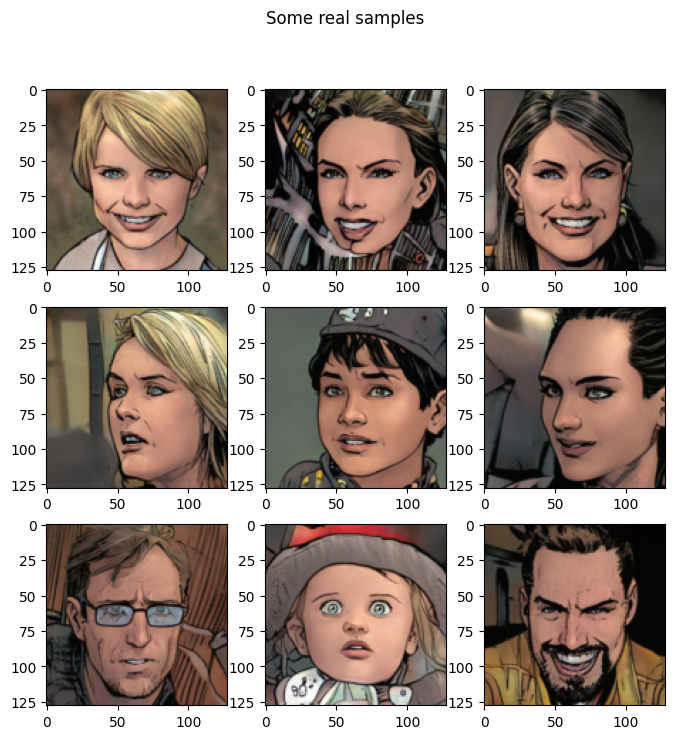

In [ ]:
# Validate Data Loading
def check_loader():
    loader, _ = get_loader(128)
    cloth, _ = next(iter(loader))
    _, ax = plt.subplots(3, 3, figsize=(8, 8))
    plt.suptitle('Sample Images from Train Set')
    ind = 0
    for k in range(3):
        for kk in range(3):
            ax[k][kk].imshow((cloth[ind].permute(1, 2, 0) + 1) / 2)
            ind += 1
    plt.show()

# Initialize Loaders and Validate
train_loader, train_dataset = get_loader(START_TRAIN_IMG_SIZE, split="train")
test_loader, test_dataset = get_loader(START_TRAIN_IMG_SIZE, split="test")
check_loader()  # Validate data loading


Defining factors that contain the numbers that will multiply with IN_CHANNELS to have the number of channels that we want in each image resolution.

In [ ]:
# Noice apping network
# AdaIN
# Progressice growing
factors = [1,1,1,1/2,1/4,1/8,1/16,1/32]

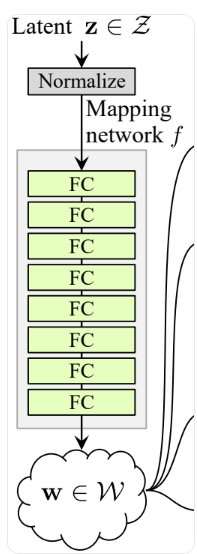

## Noise Mapping Network

In [ ]:
class WSLinear(nn.Module):
    def __init__(
        self, in_features, out_features
    ):
        super(WSLinear,self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.scale  = (2/in_features) ** 0.5
        self.bias   = self.linear.bias
        self.linear.bias = None

        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self,x):
        return self.linear(x * self.scale) + self.bias

## Using PixelNorm to normalize Z before the Noise Mapping Network.

In [ ]:
class PixenNorm(nn.Module):
    def __init__(self):
        super(PixenNorm, self).__init__()
        self.epsilon = 1e-8
    def forward(self,x ):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True)+  self.epsilon)

## Defining Mapping Network Class

In [ ]:
class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            PixenNorm(),
            WSLinear(z_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )

    def forward(self,x):
        return self.mapping(x)

## Adaptive Instance Normalization (AdaIN)

In [ ]:
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale   = WSLinear(w_dim, channels)
        self.style_bias    = WSLinear(w_dim, channels)

    def forward(self,x,w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias  = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias

## Inject Noise

In [ ]:
class injectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1,channels,1,1))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device = x.device)
        return x + self.weight + noise

## Generator Implementation

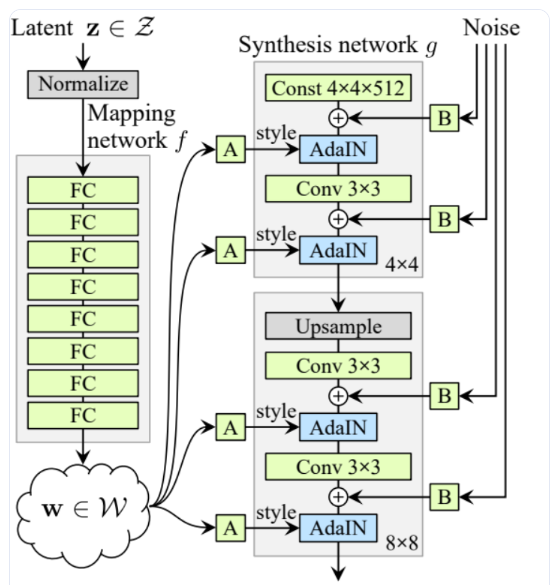

In [ ]:
class GenBlock(nn.Module):
    def __init__(self, in_channel, out_channel, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channel, out_channel)
        self.conv2 = WSConv2d(out_channel, out_channel)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = injectNoise(out_channel)
        self.inject_noise2 = injectNoise(out_channel)
        self.adain1 = AdaIN(out_channel, w_dim)
        self.adain2 = AdaIN(out_channel, w_dim)
    def forward(self, x,w):
        x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
        x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
        return x

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, w_dim, in_channels, img_channels=3):
        super().__init__()
        self.starting_cte = nn.Parameter(torch.ones(1, in_channels, 4,4))
        self.map = MappingNetwork(z_dim, w_dim)
        self.initial_adain1 = AdaIN(in_channels, w_dim)
        self.initial_adain2 = AdaIN(in_channels, w_dim)
        self.initial_noise1 = injectNoise(in_channels)
        self.initial_noise2 = injectNoise(in_channels)
        self.initial_conv   = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.leaky          = nn.LeakyReLU(0.2, inplace=True)

        self.initial_rgb    = WSConv2d(
            in_channels, img_channels, kernel_size = 1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb])
        )

        for i in range(len(factors)-1):
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i+1])
            self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
            self.rgb_layers.append(WSConv2d(conv_out_c, img_channels, kernel_size = 1, stride=1, padding=0))

    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1-alpha ) * upscaled)

    def forward(self, noise, alpha, steps):
        w = self.map(noise)
        x = self.initial_adain1(self.initial_noise1(self.starting_cte),w)
        x = self.initial_conv(x)
        out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)

        if steps == 0:
            return self.initial_rgb(x)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode = 'bilinear')
            out      = self.prog_blocks[step](upscaled,w)

        final_upscaled = self.rgb_layers[steps-1](upscaled)
        final_out      = self.rgb_layers[steps](out)

        return self.fade_in(alpha, final_upscaled, final_out)

## Defining ConvBlock which will help to create Discriminator

In [ ]:
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        return x

## Discriminator Implementation

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [ ]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()

In [ ]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

## Training Function

In [ ]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen
):
    loop = tqdm(loader, leave=True)

    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        noise = torch.randn(cur_batch_size, Z_DIm).to(DEVICE)
        fake  = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001) * torch.mean(critic_real ** 2)
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        alpha += cur_batch_size / (
            PROGRESSIVE_EPOCHS[step] * 0.5 * len(dataset)
        )
        alpha = min(alpha,1)


        loop.set_postfix(
            gp = gp.item(),
            loss_critic = loss_critic.item()
        )
    return alpha

## Sample Generation

In [ ]:
def generate_examples(gen, steps, n=5):
    """Generate and display examples at the current image resolution."""
    gen.eval()
    alpha = 1.0
    fig, ax = plt.subplots(1, n, figsize=(15, 5))  # 1 row, 5 images
    plt.suptitle(f"Generated Images at Step {steps} (Resolution: {4 * 2 ** steps}x{4 * 2 ** steps})")

    with torch.no_grad():
        for i in range(n):
            # Generate random noise
            noise = torch.randn(1, Z_DIm).to(DEVICE)
            img = gen(noise, alpha, steps)

            # Save the original tensor image
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img * 0.5 + 0.5, f"saved_examples/step{steps}/img_{i}.png")

            # Convert to NumPy for display
            img_np = (img * 0.5 + 0.5).clamp(0, 1).squeeze(0).permute(1, 2, 0).cpu().numpy()
            ax[i].imshow(img_np)
            ax[i].axis('off')

    plt.tight_layout()
    plt.show()
    gen.train()


## FID Calculation

In [ ]:
def calculate_fid(gen, real_loader, steps, n_samples=500):
    fid = FrechetInceptionDistance(feature=2048).to(DEVICE)
    gen.eval()
    alpha = 1.0

    # Compute FID for real images
    for real, _ in tqdm(real_loader, desc="Calculating FID (real images)"):
        real_uint8 = (real * 255).byte()  # Convert to uint8
        fid.update(real_uint8.to(DEVICE), real=True)

    # Compute FID for generated images
    for _ in range(n_samples):
        noise = torch.randn(1, Z_DIm).to(DEVICE)
        with torch.no_grad():
            fake = gen(noise, alpha, steps)
            fake_uint8 = ((fake * 0.5 + 0.5) * 255).clamp(0, 255).byte()  # Convert to uint8
        fid.update(fake_uint8, real=False)

    fid_score = fid.compute()
    print(f"FID at Step {steps}: {fid_score}")
    return fid_score


## PPL Calculation

In [ ]:
from torchvision.models import vgg16
def calculate_ppl(generator, steps, n_samples=100, eps=1e-4, latent_dim=512):
    """
    Calculates Perceptual Path Length (PPL) for the generator.
    Args:
        generator: The generator model.
        steps: Current resolution step.
        n_samples: Number of random samples for PPL calculation.
        eps: Small step for interpolation in latent space.
        latent_dim: Dimension of the latent vector.
    Returns:
        ppl_score: Average perceptual path length score.
    """
    generator.eval()
    vgg = vgg16(pretrained=True).features[:16].to(DEVICE).eval()  # VGG16 as perceptual feature extractor
    perceptual_differences = []

    with torch.no_grad():
        for _ in range(n_samples):
            # Sample two random latent vectors
            z1 = torch.randn(1, latent_dim).to(DEVICE)
            z2 = torch.randn(1, latent_dim).to(DEVICE)

            # Interpolation with small step
            delta_z = z2 - z1
            z_mid = z1 + eps * delta_z / torch.norm(delta_z)

            # Generate images
            img1 = generator(z1, alpha=1.0, steps=steps)
            img2 = generator(z_mid, alpha=1.0, steps=steps)

            # Extract VGG features
            feat1 = vgg((img1 * 0.5 + 0.5).clamp(0, 1))  # Normalized to [0,1]
            feat2 = vgg((img2 * 0.5 + 0.5).clamp(0, 1))

            # Compute perceptual difference
            perceptual_diff = torch.norm(feat2 - feat1) / eps
            perceptual_differences.append(perceptual_diff.item())

    ppl_score = sum(perceptual_differences) / len(perceptual_differences)
    print(f"PPL at Step {steps}: {ppl_score}")
    return ppl_score


## Training

Current image size: 4
Epoch [1/40]


100%|██████████| 40/40 [00:40<00:00,  1.01s/it, gp=4.23, loss_critic=-71.7]


Epoch [2/40]


100%|██████████| 40/40 [00:41<00:00,  1.04s/it, gp=3, loss_critic=-11.8]   


Epoch [3/40]


100%|██████████| 40/40 [00:41<00:00,  1.04s/it, gp=1.69, loss_critic=-9.45]


Epoch [4/40]


100%|██████████| 40/40 [00:41<00:00,  1.03s/it, gp=0.733, loss_critic=-17.2]


Epoch [5/40]


100%|██████████| 40/40 [00:41<00:00,  1.04s/it, gp=0.599, loss_critic=-15.8]


Epoch [6/40]


100%|██████████| 40/40 [00:41<00:00,  1.04s/it, gp=0.694, loss_critic=-15.2]


Epoch [7/40]


100%|██████████| 40/40 [00:40<00:00,  1.02s/it, gp=0.618, loss_critic=-17.4]


Epoch [8/40]


100%|██████████| 40/40 [00:41<00:00,  1.03s/it, gp=0.543, loss_critic=-17.5]


Epoch [9/40]


100%|██████████| 40/40 [00:42<00:00,  1.05s/it, gp=0.548, loss_critic=-19.2]


Epoch [10/40]


100%|██████████| 40/40 [00:41<00:00,  1.04s/it, gp=0.571, loss_critic=-22.8]


Epoch [11/40]


100%|██████████| 40/40 [00:41<00:00,  1.04s/it, gp=0.462, loss_critic=-22.7]


Epoch [12/40]


100%|██████████| 40/40 [00:43<00:00,  1.08s/it, gp=0.408, loss_critic=-14.3]


Epoch [13/40]


100%|██████████| 40/40 [00:42<00:00,  1.06s/it, gp=0.28, loss_critic=-11.5] 


Epoch [14/40]


100%|██████████| 40/40 [00:41<00:00,  1.05s/it, gp=0.875, loss_critic=-23.7]


Epoch [15/40]


100%|██████████| 40/40 [00:41<00:00,  1.05s/it, gp=0.246, loss_critic=-8.55]


Epoch [16/40]


100%|██████████| 40/40 [00:41<00:00,  1.05s/it, gp=0.295, loss_critic=-13.5]


Epoch [17/40]


100%|██████████| 40/40 [00:42<00:00,  1.05s/it, gp=0.417, loss_critic=-12.7]


Epoch [18/40]


100%|██████████| 40/40 [00:41<00:00,  1.05s/it, gp=0.378, loss_critic=-14.7]


Epoch [19/40]


100%|██████████| 40/40 [00:42<00:00,  1.05s/it, gp=0.407, loss_critic=-9.71]


Epoch [20/40]


100%|██████████| 40/40 [00:41<00:00,  1.05s/it, gp=0.247, loss_critic=-14.5]


Epoch [21/40]


100%|██████████| 40/40 [00:40<00:00,  1.02s/it, gp=0.241, loss_critic=-14.6]


Epoch [22/40]


100%|██████████| 40/40 [00:42<00:00,  1.05s/it, gp=0.523, loss_critic=-18.1]


Epoch [23/40]


100%|██████████| 40/40 [00:42<00:00,  1.06s/it, gp=0.571, loss_critic=-20.8]


Epoch [24/40]


100%|██████████| 40/40 [00:41<00:00,  1.04s/it, gp=0.274, loss_critic=-9.74]


Epoch [25/40]


100%|██████████| 40/40 [00:41<00:00,  1.05s/it, gp=0.227, loss_critic=-12.1]


Epoch [26/40]


100%|██████████| 40/40 [00:42<00:00,  1.06s/it, gp=0.204, loss_critic=-11.5]


Epoch [27/40]


100%|██████████| 40/40 [00:42<00:00,  1.05s/it, gp=0.154, loss_critic=-7.35]


Epoch [28/40]


100%|██████████| 40/40 [00:41<00:00,  1.05s/it, gp=0.18, loss_critic=-6.04] 


Epoch [29/40]


100%|██████████| 40/40 [00:42<00:00,  1.05s/it, gp=0.197, loss_critic=-6.76]


Epoch [30/40]


100%|██████████| 40/40 [00:41<00:00,  1.04s/it, gp=0.141, loss_critic=-7.21] 


Epoch [31/40]


100%|██████████| 40/40 [00:40<00:00,  1.02s/it, gp=0.179, loss_critic=-9.77] 


Epoch [32/40]


100%|██████████| 40/40 [00:41<00:00,  1.03s/it, gp=0.113, loss_critic=-7.6]  


Epoch [33/40]


100%|██████████| 40/40 [00:42<00:00,  1.05s/it, gp=0.214, loss_critic=-6.78] 


Epoch [34/40]


100%|██████████| 40/40 [00:42<00:00,  1.05s/it, gp=0.0513, loss_critic=-2.96]


Epoch [35/40]


100%|██████████| 40/40 [00:42<00:00,  1.05s/it, gp=0.0579, loss_critic=-4.62]


Epoch [36/40]


100%|██████████| 40/40 [00:41<00:00,  1.04s/it, gp=0.0709, loss_critic=-5.48]


Epoch [37/40]


100%|██████████| 40/40 [00:41<00:00,  1.03s/it, gp=0.069, loss_critic=-4.85] 


Epoch [38/40]


100%|██████████| 40/40 [00:40<00:00,  1.02s/it, gp=0.0828, loss_critic=-6.76]


Epoch [39/40]


100%|██████████| 40/40 [00:41<00:00,  1.04s/it, gp=0.0643, loss_critic=-3.76]


Epoch [40/40]


100%|██████████| 40/40 [00:42<00:00,  1.05s/it, gp=0.0862, loss_critic=-4.85]


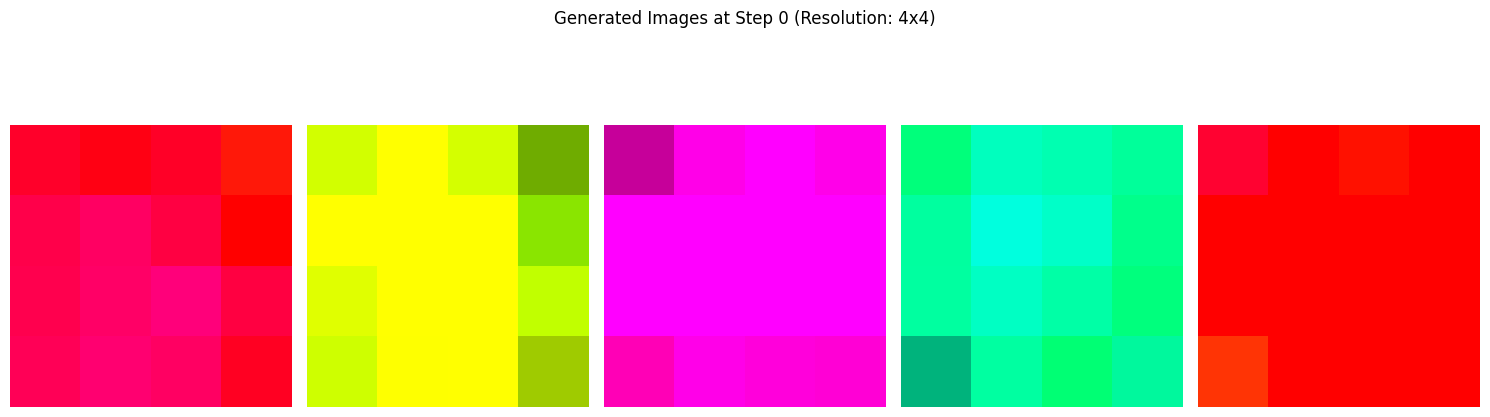

Calculating FID (real images): 100%|██████████| 40/40 [00:36<00:00,  1.09it/s]


FID at Step 0: 148.58001708984375
PPL at Step 0: 25075.669697265625
Current image size: 8
Epoch [1/40]


100%|██████████| 40/40 [00:47<00:00,  1.18s/it, gp=0.0446, loss_critic=-2.98]


Epoch [2/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0266, loss_critic=-2.86]


Epoch [3/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0369, loss_critic=-3.07]


Epoch [4/40]


100%|██████████| 40/40 [00:47<00:00,  1.18s/it, gp=0.0454, loss_critic=-2.13]


Epoch [5/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0281, loss_critic=-2.7] 


Epoch [6/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.026, loss_critic=-2.94] 


Epoch [7/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.04, loss_critic=-2.84]  


Epoch [8/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.022, loss_critic=-2.72] 


Epoch [9/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0275, loss_critic=-2.45]


Epoch [10/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0275, loss_critic=-2.08]


Epoch [11/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0515, loss_critic=-3.47]


Epoch [12/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0421, loss_critic=-3.18]


Epoch [13/40]


100%|██████████| 40/40 [00:47<00:00,  1.18s/it, gp=0.0337, loss_critic=-3.2] 


Epoch [14/40]


100%|██████████| 40/40 [00:47<00:00,  1.19s/it, gp=0.049, loss_critic=-3.2]   


Epoch [15/40]


100%|██████████| 40/40 [00:47<00:00,  1.18s/it, gp=0.016, loss_critic=-2.91] 


Epoch [16/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0265, loss_critic=-3.1] 


Epoch [17/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0221, loss_critic=-3.61]


Epoch [18/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0357, loss_critic=-3.29]


Epoch [19/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0551, loss_critic=-3.76]


Epoch [20/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0292, loss_critic=-4.18]


Epoch [21/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0619, loss_critic=-3.83]


Epoch [22/40]


100%|██████████| 40/40 [00:46<00:00,  1.16s/it, gp=0.0483, loss_critic=-3.45]


Epoch [23/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0364, loss_critic=-2.6] 


Epoch [24/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0208, loss_critic=-2.17]


Epoch [25/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0332, loss_critic=-3.59]


Epoch [26/40]


100%|██████████| 40/40 [00:46<00:00,  1.16s/it, gp=0.018, loss_critic=-2.23] 


Epoch [27/40]


100%|██████████| 40/40 [00:46<00:00,  1.16s/it, gp=0.0167, loss_critic=-2.14]


Epoch [28/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0551, loss_critic=-3.66]


Epoch [29/40]


100%|██████████| 40/40 [00:46<00:00,  1.16s/it, gp=0.02, loss_critic=-2.42]  


Epoch [30/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0354, loss_critic=-2.35]


Epoch [31/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0281, loss_critic=-2.62]


Epoch [32/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.045, loss_critic=-2.46] 


Epoch [33/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0163, loss_critic=-1.76]


Epoch [34/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0323, loss_critic=-2.01]


Epoch [35/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0563, loss_critic=-2.53]


Epoch [36/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0188, loss_critic=-1.99]


Epoch [37/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.00766, loss_critic=-2.12]


Epoch [38/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0104, loss_critic=-1.9] 


Epoch [39/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0202, loss_critic=-1.55]


Epoch [40/40]


100%|██████████| 40/40 [00:46<00:00,  1.17s/it, gp=0.0299, loss_critic=-1.76] 


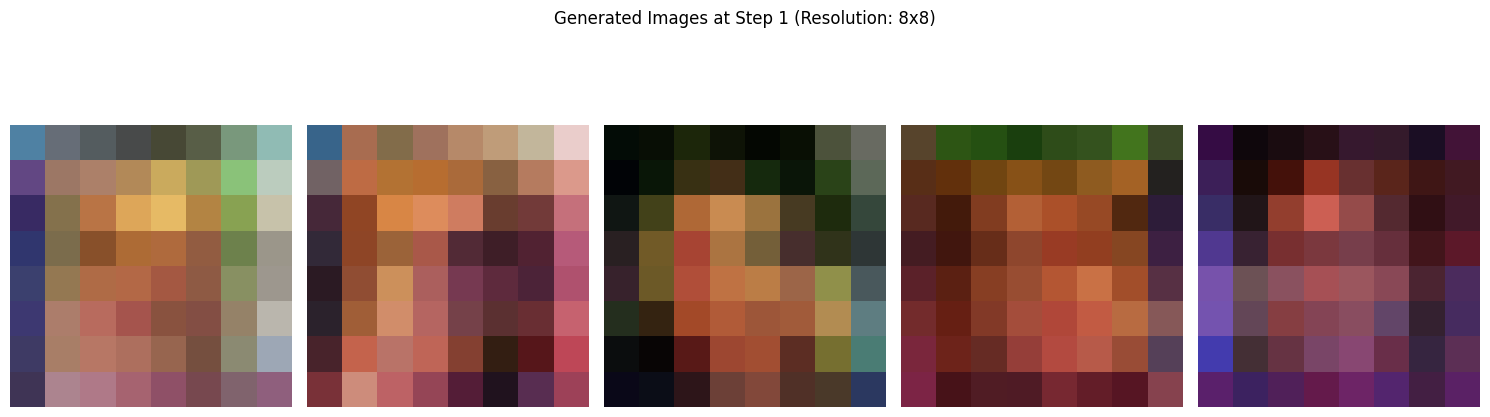

Calculating FID (real images): 100%|██████████| 40/40 [00:37<00:00,  1.08it/s]


FID at Step 1: 156.9522247314453
PPL at Step 1: 313834.1565625
Current image size: 16
Epoch [1/40]


100%|██████████| 79/79 [01:07<00:00,  1.18it/s, gp=0.0565, loss_critic=-4.04]


Epoch [2/40]


100%|██████████| 79/79 [01:06<00:00,  1.18it/s, gp=0.051, loss_critic=-3.25] 


Epoch [3/40]


100%|██████████| 79/79 [01:06<00:00,  1.18it/s, gp=0.0506, loss_critic=-3.52]


Epoch [4/40]


100%|██████████| 79/79 [01:06<00:00,  1.18it/s, gp=0.0744, loss_critic=-2.43]


Epoch [5/40]


100%|██████████| 79/79 [01:06<00:00,  1.18it/s, gp=0.0189, loss_critic=-3.83]


Epoch [6/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.0169, loss_critic=-4.18]


Epoch [7/40]


100%|██████████| 79/79 [01:06<00:00,  1.18it/s, gp=0.0754, loss_critic=-6.07]


Epoch [8/40]


100%|██████████| 79/79 [01:07<00:00,  1.18it/s, gp=0.0243, loss_critic=-4.04]


Epoch [9/40]


100%|██████████| 79/79 [01:06<00:00,  1.18it/s, gp=0.0408, loss_critic=-3.84]


Epoch [10/40]


100%|██████████| 79/79 [01:06<00:00,  1.18it/s, gp=0.0628, loss_critic=-3.26]


Epoch [11/40]


100%|██████████| 79/79 [01:06<00:00,  1.18it/s, gp=0.0245, loss_critic=-3.79]


Epoch [12/40]


100%|██████████| 79/79 [01:06<00:00,  1.18it/s, gp=0.1, loss_critic=-4.04]   


Epoch [13/40]


100%|██████████| 79/79 [01:06<00:00,  1.18it/s, gp=0.0999, loss_critic=-4.17]


Epoch [14/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.031, loss_critic=-3.45] 


Epoch [15/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.0271, loss_critic=-3.32]


Epoch [16/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.0517, loss_critic=-3.81]


Epoch [17/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.0733, loss_critic=-3.76]


Epoch [18/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.0192, loss_critic=-2.96]


Epoch [19/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.0353, loss_critic=-3.13] 


Epoch [20/40]


100%|██████████| 79/79 [01:06<00:00,  1.18it/s, gp=0.0441, loss_critic=-3.5]  


Epoch [21/40]


100%|██████████| 79/79 [01:07<00:00,  1.18it/s, gp=0.0356, loss_critic=-3.9] 


Epoch [22/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.0283, loss_critic=-3.91]


Epoch [23/40]


100%|██████████| 79/79 [01:06<00:00,  1.18it/s, gp=0.0186, loss_critic=-2.84]


Epoch [24/40]


100%|██████████| 79/79 [01:06<00:00,  1.18it/s, gp=0.0248, loss_critic=-2.41]


Epoch [25/40]


100%|██████████| 79/79 [01:06<00:00,  1.18it/s, gp=0.0297, loss_critic=-3.35]


Epoch [26/40]


100%|██████████| 79/79 [01:06<00:00,  1.18it/s, gp=0.0201, loss_critic=-2.5]  


Epoch [27/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.0414, loss_critic=-3.02]


Epoch [28/40]


100%|██████████| 79/79 [01:06<00:00,  1.18it/s, gp=0.0247, loss_critic=-2.68] 


Epoch [29/40]


100%|██████████| 79/79 [01:05<00:00,  1.20it/s, gp=0.013, loss_critic=-2.32]  


Epoch [30/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.00509, loss_critic=-2.01]


Epoch [31/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.0216, loss_critic=-1.55] 


Epoch [32/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.0116, loss_critic=-1.75] 


Epoch [33/40]


100%|██████████| 79/79 [01:06<00:00,  1.18it/s, gp=0.0673, loss_critic=-2.04] 


Epoch [34/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.0369, loss_critic=-1.97] 


Epoch [35/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.0236, loss_critic=-2.35] 


Epoch [36/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.0125, loss_critic=-2.01] 


Epoch [37/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.0111, loss_critic=-1.58] 


Epoch [38/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.00661, loss_critic=-1.7] 


Epoch [39/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.00894, loss_critic=-1.56]


Epoch [40/40]


100%|██████████| 79/79 [01:06<00:00,  1.19it/s, gp=0.0132, loss_critic=-1.35] 


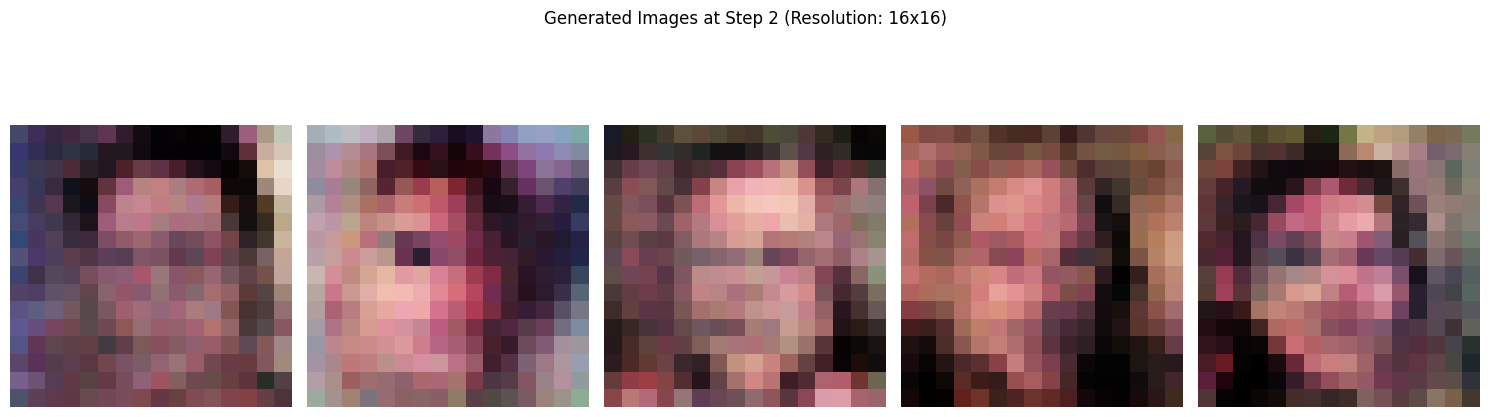

Calculating FID (real images): 100%|██████████| 79/79 [00:37<00:00,  2.12it/s]


FID at Step 2: 193.73944091796875
PPL at Step 2: 933685.925
Current image size: 32
Epoch [1/40]


100%|██████████| 157/157 [02:18<00:00,  1.13it/s, gp=0.0649, loss_critic=-2.4]  


Epoch [2/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.0361, loss_critic=-3.24] 


Epoch [3/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.0187, loss_critic=-2.78]


Epoch [4/40]


100%|██████████| 157/157 [01:57<00:00,  1.34it/s, gp=0.0213, loss_critic=-2.94] 


Epoch [5/40]


100%|██████████| 157/157 [01:57<00:00,  1.34it/s, gp=0.00978, loss_critic=-3]   


Epoch [6/40]


100%|██████████| 157/157 [01:57<00:00,  1.34it/s, gp=0.0185, loss_critic=-2.98] 


Epoch [7/40]


100%|██████████| 157/157 [01:57<00:00,  1.34it/s, gp=0.00708, loss_critic=-2.61]


Epoch [8/40]


100%|██████████| 157/157 [01:57<00:00,  1.34it/s, gp=0.00808, loss_critic=-2.58]


Epoch [9/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.0466, loss_critic=-3.29] 


Epoch [10/40]


100%|██████████| 157/157 [01:58<00:00,  1.32it/s, gp=0.019, loss_critic=-3.36]  


Epoch [11/40]


100%|██████████| 157/157 [01:58<00:00,  1.33it/s, gp=0.0366, loss_critic=-2.71] 


Epoch [12/40]


100%|██████████| 157/157 [01:57<00:00,  1.34it/s, gp=0.029, loss_critic=-2.56]  


Epoch [13/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.0468, loss_critic=-2.41] 


Epoch [14/40]


100%|██████████| 157/157 [02:04<00:00,  1.26it/s, gp=0.00857, loss_critic=-2.02]


Epoch [15/40]


100%|██████████| 157/157 [02:03<00:00,  1.27it/s, gp=0.0153, loss_critic=-2.18] 


Epoch [16/40]


100%|██████████| 157/157 [02:02<00:00,  1.28it/s, gp=0.108, loss_critic=-1.92]  


Epoch [17/40]


100%|██████████| 157/157 [01:58<00:00,  1.32it/s, gp=0.0337, loss_critic=-3.98] 


Epoch [18/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.0121, loss_critic=-1.97] 


Epoch [19/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.0174, loss_critic=-2.37] 


Epoch [20/40]


100%|██████████| 157/157 [01:57<00:00,  1.34it/s, gp=0.0132, loss_critic=-3.06] 


Epoch [21/40]


100%|██████████| 157/157 [01:57<00:00,  1.34it/s, gp=0.0353, loss_critic=-1.69] 


Epoch [22/40]


100%|██████████| 157/157 [01:58<00:00,  1.32it/s, gp=0.0824, loss_critic=-1.88] 


Epoch [23/40]


100%|██████████| 157/157 [01:59<00:00,  1.31it/s, gp=0.0136, loss_critic=-2.05] 


Epoch [24/40]


100%|██████████| 157/157 [01:59<00:00,  1.32it/s, gp=0.0272, loss_critic=-1.8]  


Epoch [25/40]


100%|██████████| 157/157 [01:59<00:00,  1.31it/s, gp=0.0172, loss_critic=-1.8]  


Epoch [26/40]


100%|██████████| 157/157 [02:00<00:00,  1.31it/s, gp=0.0122, loss_critic=-1.73] 


Epoch [27/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.00319, loss_critic=-1.22]


Epoch [28/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.0156, loss_critic=-1.24] 


Epoch [29/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.0166, loss_critic=-1.63] 


Epoch [30/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.015, loss_critic=-1.46]  


Epoch [31/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.00953, loss_critic=-1.77]


Epoch [32/40]


100%|██████████| 157/157 [01:58<00:00,  1.33it/s, gp=0.0174, loss_critic=-1.13] 


Epoch [33/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.0146, loss_critic=-1.74] 


Epoch [34/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.0127, loss_critic=-2.04] 


Epoch [35/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.00927, loss_critic=-1.72]


Epoch [36/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.0202, loss_critic=-1.67] 


Epoch [37/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.00932, loss_critic=-1.2] 


Epoch [38/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.0172, loss_critic=-1.44] 


Epoch [39/40]


100%|██████████| 157/157 [01:58<00:00,  1.33it/s, gp=0.00327, loss_critic=-1.26]


Epoch [40/40]


100%|██████████| 157/157 [01:57<00:00,  1.33it/s, gp=0.00738, loss_critic=-.964]


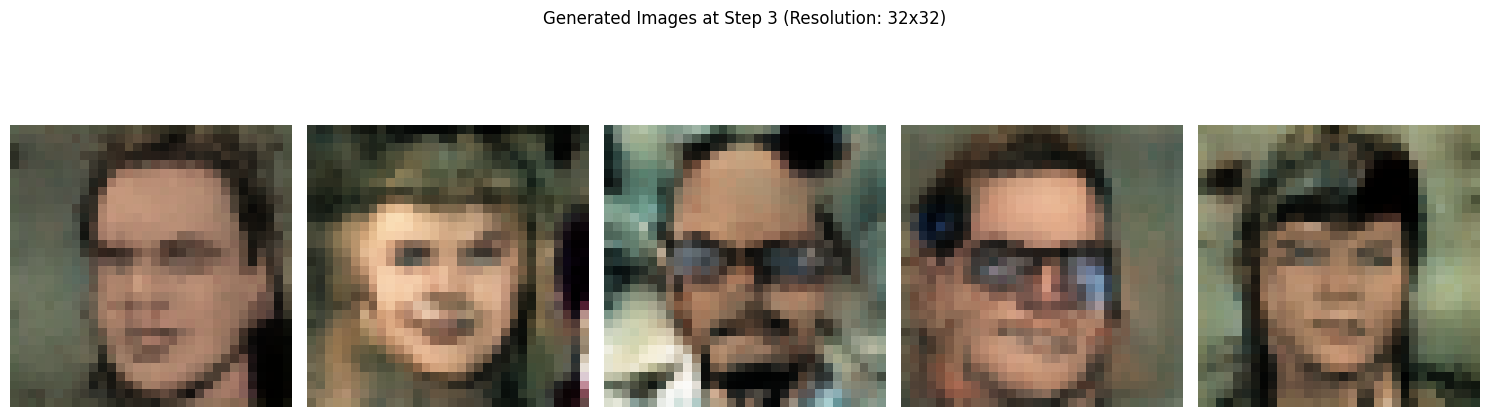

Calculating FID (real images): 100%|██████████| 157/157 [00:38<00:00,  4.06it/s]


FID at Step 3: 246.0104217529297
PPL at Step 3: 2340579.39125
Current image size: 64
Epoch [1/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0232, loss_critic=-4.19] 


Epoch [2/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0757, loss_critic=-4.49]


Epoch [3/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0686, loss_critic=-4.41]


Epoch [4/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0798, loss_critic=-4.27]


Epoch [5/40]


100%|██████████| 313/313 [03:13<00:00,  1.61it/s, gp=0.0635, loss_critic=-5.51]


Epoch [6/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0544, loss_critic=-5.73]


Epoch [7/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0544, loss_critic=-5.3] 


Epoch [8/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0895, loss_critic=-5.35]


Epoch [9/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0425, loss_critic=-4.13]


Epoch [10/40]


100%|██████████| 313/313 [03:15<00:00,  1.60it/s, gp=0.0387, loss_critic=-3.69]


Epoch [11/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0289, loss_critic=-4.16]


Epoch [12/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0368, loss_critic=-4.1] 


Epoch [13/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0282, loss_critic=-3.76]


Epoch [14/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0358, loss_critic=-4.83]


Epoch [15/40]


100%|██████████| 313/313 [03:13<00:00,  1.62it/s, gp=0.0435, loss_critic=-5.21]


Epoch [16/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.03, loss_critic=-3.09]  


Epoch [17/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0382, loss_critic=-3.07]


Epoch [18/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0214, loss_critic=-2.73]


Epoch [19/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0439, loss_critic=-4.7] 


Epoch [20/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0653, loss_critic=-3.07]


Epoch [21/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0367, loss_critic=-3.57]


Epoch [22/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0342, loss_critic=-2.97]


Epoch [23/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0467, loss_critic=-3.61]


Epoch [24/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0394, loss_critic=-2.03]


Epoch [25/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0332, loss_critic=-3.76]


Epoch [26/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0364, loss_critic=-3.42]


Epoch [27/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0346, loss_critic=-2.82]


Epoch [28/40]


100%|██████████| 313/313 [03:15<00:00,  1.60it/s, gp=0.0207, loss_critic=-3.16]


Epoch [29/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0231, loss_critic=-3.46] 


Epoch [30/40]


100%|██████████| 313/313 [03:15<00:00,  1.60it/s, gp=0.016, loss_critic=-2.15] 


Epoch [31/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0403, loss_critic=-1.99] 


Epoch [32/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.037, loss_critic=-1.65]  


Epoch [33/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0365, loss_critic=-3.38] 


Epoch [34/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0128, loss_critic=-2.74] 


Epoch [35/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0219, loss_critic=-2.31] 


Epoch [36/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0364, loss_critic=-1.39] 


Epoch [37/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.02, loss_critic=-2.19]   


Epoch [38/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.00979, loss_critic=-3.34]


Epoch [39/40]


100%|██████████| 313/313 [03:15<00:00,  1.60it/s, gp=0.0253, loss_critic=-3.06] 


Epoch [40/40]


100%|██████████| 313/313 [03:14<00:00,  1.61it/s, gp=0.0373, loss_critic=-3.33] 


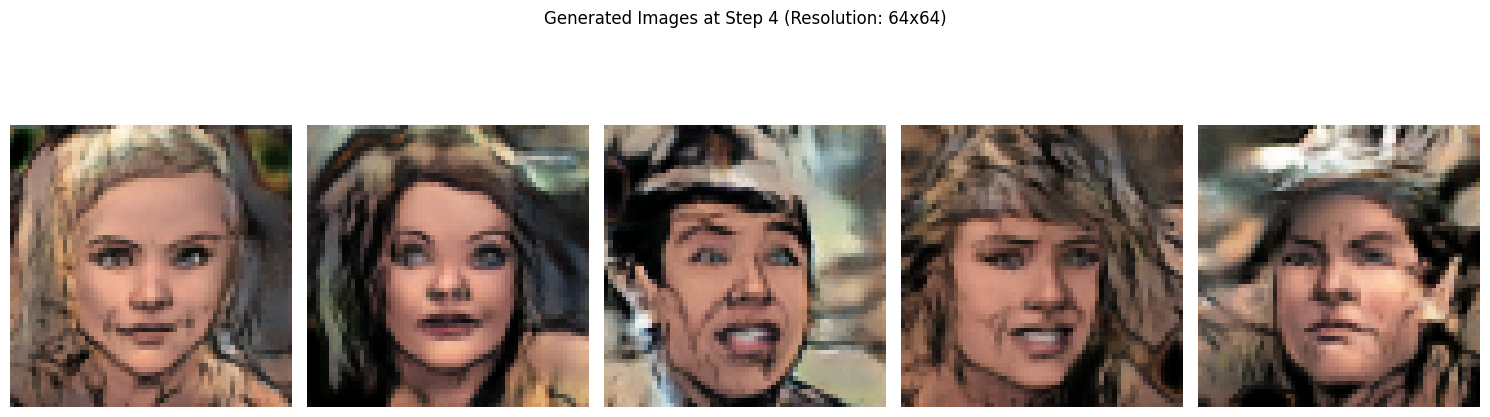

Calculating FID (real images): 100%|██████████| 313/313 [00:41<00:00,  7.52it/s]


FID at Step 4: 163.1747283935547
PPL at Step 4: 5085526.1025
Current image size: 128
Epoch [1/40]


100%|██████████| 625/625 [05:41<00:00,  1.83it/s, gp=0.156, loss_critic=-2.81] 


Epoch [2/40]


100%|██████████| 625/625 [05:41<00:00,  1.83it/s, gp=0.156, loss_critic=-11.8] 


Epoch [3/40]


100%|██████████| 625/625 [05:38<00:00,  1.85it/s, gp=0.0923, loss_critic=-9.36]


Epoch [4/40]


100%|██████████| 625/625 [05:40<00:00,  1.84it/s, gp=0.119, loss_critic=-8.05] 


Epoch [5/40]


100%|██████████| 625/625 [05:39<00:00,  1.84it/s, gp=0.231, loss_critic=-6.7]  


Epoch [6/40]


100%|██████████| 625/625 [05:40<00:00,  1.83it/s, gp=0.0858, loss_critic=-8.55]


Epoch [7/40]


100%|██████████| 625/625 [05:40<00:00,  1.83it/s, gp=0.0956, loss_critic=-7.92]


Epoch [8/40]


100%|██████████| 625/625 [05:40<00:00,  1.84it/s, gp=0.0638, loss_critic=-9.48]


Epoch [9/40]


100%|██████████| 625/625 [05:41<00:00,  1.83it/s, gp=0.0879, loss_critic=-8.14]


Epoch [10/40]


100%|██████████| 625/625 [05:40<00:00,  1.83it/s, gp=0.0663, loss_critic=-7.02]


Epoch [11/40]


100%|██████████| 625/625 [05:40<00:00,  1.83it/s, gp=0.117, loss_critic=-7.14] 


Epoch [12/40]


100%|██████████| 625/625 [05:40<00:00,  1.83it/s, gp=0.0598, loss_critic=-7.29]


Epoch [13/40]


100%|██████████| 625/625 [05:40<00:00,  1.83it/s, gp=0.0609, loss_critic=-6.95]


Epoch [14/40]


100%|██████████| 625/625 [05:41<00:00,  1.83it/s, gp=0.117, loss_critic=-6.58] 


Epoch [15/40]


100%|██████████| 625/625 [05:41<00:00,  1.83it/s, gp=0.0636, loss_critic=-8.21] 


Epoch [16/40]


100%|██████████| 625/625 [05:40<00:00,  1.83it/s, gp=0.199, loss_critic=-8.21] 


Epoch [17/40]


100%|██████████| 625/625 [05:40<00:00,  1.84it/s, gp=0.0719, loss_critic=-5.55]


Epoch [18/40]


100%|██████████| 625/625 [05:40<00:00,  1.84it/s, gp=0.0686, loss_critic=-4.41]


Epoch [19/40]


100%|██████████| 625/625 [05:40<00:00,  1.83it/s, gp=0.0979, loss_critic=-6.87]


Epoch [20/40]


100%|██████████| 625/625 [05:41<00:00,  1.83it/s, gp=0.0948, loss_critic=-8.45]


Epoch [21/40]


100%|██████████| 625/625 [05:39<00:00,  1.84it/s, gp=0.133, loss_critic=-6.33] 


Epoch [22/40]


100%|██████████| 625/625 [05:40<00:00,  1.84it/s, gp=0.0918, loss_critic=-5.94]


Epoch [23/40]


100%|██████████| 625/625 [05:40<00:00,  1.84it/s, gp=0.0976, loss_critic=-3.83] 


Epoch [24/40]


100%|██████████| 625/625 [05:40<00:00,  1.84it/s, gp=0.0829, loss_critic=-6.21]


Epoch [25/40]


100%|██████████| 625/625 [05:41<00:00,  1.83it/s, gp=0.0786, loss_critic=-5.8]  


Epoch [26/40]


100%|██████████| 625/625 [05:40<00:00,  1.84it/s, gp=0.0519, loss_critic=-7.95]


Epoch [27/40]


100%|██████████| 625/625 [05:40<00:00,  1.83it/s, gp=0.106, loss_critic=-2.84] 


Epoch [28/40]


100%|██████████| 625/625 [05:40<00:00,  1.84it/s, gp=0.0664, loss_critic=-6.79]


Epoch [29/40]


100%|██████████| 625/625 [05:40<00:00,  1.83it/s, gp=0.0676, loss_critic=-5.22]


Epoch [30/40]


100%|██████████| 625/625 [05:42<00:00,  1.83it/s, gp=0.0322, loss_critic=-7.79]


Epoch [31/40]


100%|██████████| 625/625 [05:40<00:00,  1.83it/s, gp=0.0435, loss_critic=-4.84]


Epoch [32/40]


100%|██████████| 625/625 [05:40<00:00,  1.83it/s, gp=0.0745, loss_critic=-7.1]  


Epoch [33/40]


100%|██████████| 625/625 [05:40<00:00,  1.83it/s, gp=0.145, loss_critic=-8.6]  


Epoch [34/40]


100%|██████████| 625/625 [05:40<00:00,  1.84it/s, gp=0.151, loss_critic=-3.93] 


Epoch [35/40]


100%|██████████| 625/625 [05:41<00:00,  1.83it/s, gp=0.0547, loss_critic=-4.33]


Epoch [36/40]


100%|██████████| 625/625 [05:41<00:00,  1.83it/s, gp=0.0972, loss_critic=-6.44]


Epoch [37/40]


100%|██████████| 625/625 [05:40<00:00,  1.83it/s, gp=0.107, loss_critic=-4.75] 


Epoch [38/40]


100%|██████████| 625/625 [05:40<00:00,  1.83it/s, gp=0.159, loss_critic=-8.93] 


Epoch [39/40]


100%|██████████| 625/625 [05:40<00:00,  1.83it/s, gp=0.0351, loss_critic=-2.35]


Epoch [40/40]


100%|██████████| 625/625 [05:40<00:00,  1.84it/s, gp=0.107, loss_critic=-4.95]  


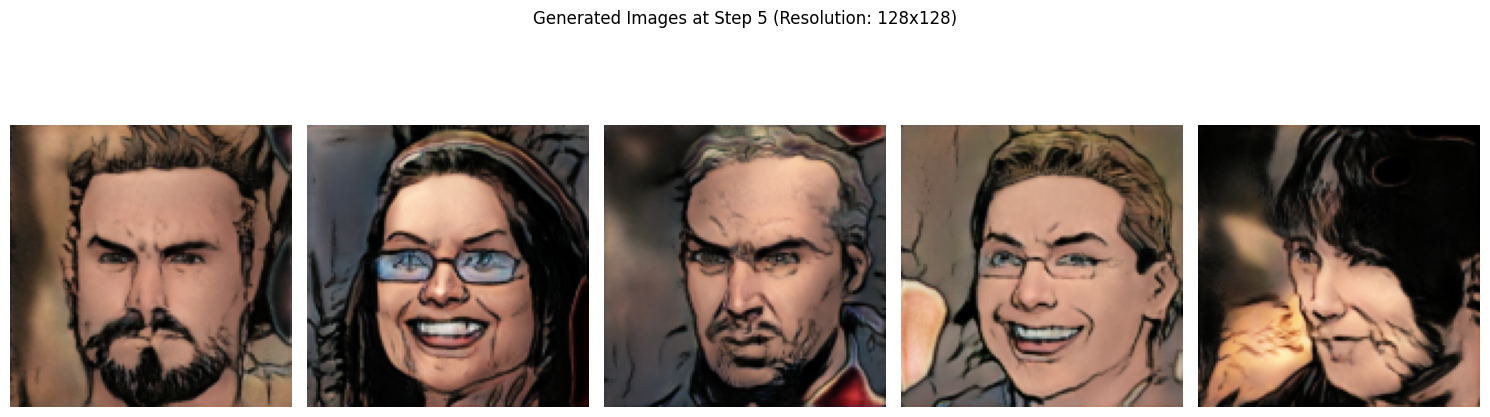

Calculating FID (real images): 100%|██████████| 625/625 [00:52<00:00, 12.01it/s]


FID at Step 5: 146.92623901367188
PPL at Step 5: 9941605.16


In [ ]:
# Initialize the Generator and Discriminator
gen = Generator(Z_DIm, W_DIM, IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)

# Optimizers
opt_gen = optim.Adam(
    [{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
     {'params': gen.map.parameters(), 'lr': 1e-5}], lr=LR, betas=(0.0, 0.99))
opt_critic = optim.Adam(critic.parameters(), lr=LR, betas=(0.0, 0.99))

# Start training
step = int(log2(START_TRAIN_IMG_SIZE / 4))  # Start at smallest resolution
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-7
    train_loader, train_dataset = get_loader(4 * 2 ** step, split="train")
    print(f"Training with resolution: {4 * 2 ** step}x{4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        alpha = train_fn(critic, gen, train_loader, train_dataset, step, alpha, opt_critic, opt_gen)

    # Generate examples and evaluate
    generate_examples(gen, step)
    test_loader, test_dataset = get_loader(4 * 2 ** step, split="test")
    fid_score = calculate_fid(gen, test_loader, step)
    print(f"FID at {4 * 2 ** step}x{4 * 2 ** step}: {fid_score}")

    step += 1
